In [5]:
# Set up GPU rendering.
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

""

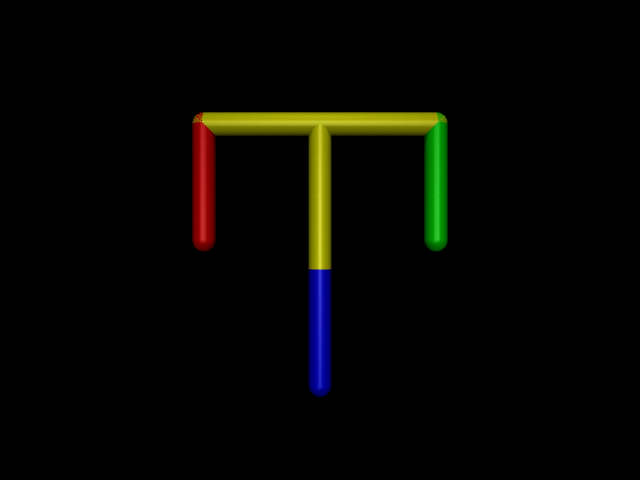

In [22]:
chaotic_pendulum = """
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)
data = mujoco.MjData(model)
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

In [23]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

# set initial state
mujoco.mj_resetData(model, data)
data.joint('root').qvel = 10

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)

simulation:  3.94 μs/step  (253691Hz)
rendering:    404 μs/frame ( 2474Hz)




""

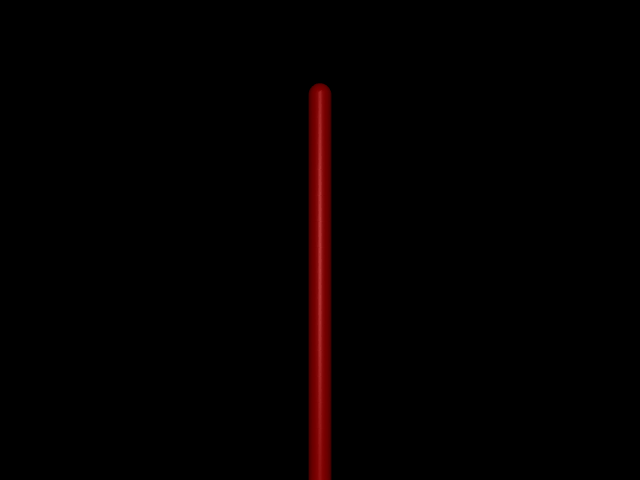

In [42]:
inverted_pendulum = '''
<mujoco>
  <option timestep="0.001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size="0.02"/>
  </default>

  <worldbody>
    <light pos="0 -1 1"/>
    <camera name="fixed" pos="0 -1 0.5" xyaxes="1 0 0 0 0 1"/>

    <!-- Base -->
    <body name="cart" pos="0 0 0">
      <geom type="box" size="0.1 0.05 0.05" rgba="0.8 0.8 0.8 1"/>

      <!-- Pendulum -->
      <body name="pole" pos="0 0 0.05">
        <joint name="hinge" type="hinge" axis="1 -1 0"/>
        <geom fromto="0 0 0 0 0 0.7" rgba="1 0 0 1"/>
      </body>
    </body>
  </worldbody>
    <actuator>
    <motor joint="hinge" gear="1"/>
  </actuator>
</mujoco>'''
model = mujoco.MjModel.from_xml_string(inverted_pendulum)
data = mujoco.MjData(model)
height = 480
width = 640

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera="fixed")

  media.show_image(renderer.render())

In [51]:
# setup
n_seconds = 6
framerate = 30  # Hz
n_frames = int(n_seconds * framerate)
frames = []
height = 240
width = 320

model = mujoco.MjModel.from_xml_string(inverted_pendulum)
data = mujoco.MjData(model)
# set initial state
mujoco.mj_resetData(model, data)
data.joint('hinge').qvel = 2

# Controller gains
Kp = 5.0
Kd = 0.5
qpos_target = 0.0
qvel_target = 0.0

# simulate and record frames
frame = 0
sim_time = 0
render_time = 0
n_steps = 0
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time * framerate < i:
      tic = time.time()
       # --- PD Controller ---
      q = data.joint('hinge').qpos
      qd = data.joint('hinge').qvel
      torque = -Kp * (q - qpos_target) - Kd * (qd - qvel_target)
      data.ctrl[0] = torque
      mujoco.mj_step(model, data)
      sim_time += time.time() - tic
      n_steps += 1
    tic = time.time()
    renderer.update_scene(data, "fixed")
    frame = renderer.render()
    render_time += time.time() - tic
    frames.append(frame)

# print timing and play video
step_time = 1e6*sim_time/n_steps
step_fps = n_steps/sim_time
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')
frame_time = 1e6*render_time/n_frames
frame_fps = n_frames/render_time
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')
print('\n')

# show video
media.show_video(frames, fps=framerate)



/tmp/ipykernel_14585/1604980038.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.ctrl[0] = torque


simulation:  13.3 μs/step  (75218Hz)
rendering:    850 μs/frame ( 1177Hz)


